## Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from data_processing import *

In [3]:
df, clustering_dict = get_clustered_data_with_bus_only('./data/SZP-2021-09-03.csv')

Amount of invalid data: 2


In [4]:
df = get_numeric_name(df, "Nazwa przystanku", drop=True)
df['Przystanek'] = df['Numeryczna Nazwa przystanku'] * 100 + df['Numer przystanku']

In [5]:
lines = split_into_lines(df, drop_line = True)

C:\Users\Patryk\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [6]:
features = ['Numer taborowy', 'Godzina odjazdu', 'Godzina odjazdu przedział', 'Przystanek']
class_labels = ["class"]
regress_labels = ["Liczba pasaz. przed"]

## Classification

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import datetime as dt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from mlxtend.evaluate import bootstrap_point632_score
from mlxtend.evaluate import BootstrapOutOfBag
from mlxtend.evaluate import bootstrap

import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
data_lines = dict()
for key, value in lines.items():
    data_lines[key] = get_train_and_test_for_lines(value, X_columns = features, y_columns = class_labels)

### DecisionTreeClassifier

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


In [17]:
model = DecisionTreeClassifier(max_depth = 1000, random_state = 1)

In [18]:
#Bootstrap Out of Bag
predicted2 = np.array([])
y_tests2 = np.array([])
for value in data_lines.values():
    X_train, X_test, y_train, y_test = value
    scores2 = cross_validate(model, X_train, y_train, cv = BootstrapOutOfBag(n_splits=5, random_seed=456), n_jobs = -1, return_estimator = True)

    predicted2 = np.concatenate((predicted2, scores2['estimator'][scores2['test_score'].argmax()].predict(X_test)), axis=0)
    y_tests2 = np.concatenate((y_tests2, y_test.to_numpy().reshape(1,-1)[0]), axis=0)
err2 = accuracy_score(predicted2, y_tests2)

In [19]:
#Repeated K-Fold
predicted3 = np.array([])
y_tests3 = np.array([])
for value in data_lines.values():
    X_train, X_test, y_train, y_test = value
    scores3 = cross_validate(model, X_train, y_train, n_jobs = -1, cv = RepeatedKFold(n_splits = 10, n_repeats = 2), return_estimator = True)

    predicted3 = np.concatenate((predicted3, scores3['estimator'][scores3['test_score'].argmax()].predict(X_test)), axis=0)
    y_tests3 = np.concatenate((y_tests3, y_test.to_numpy().reshape(1,-1)[0]), axis=0)
err3 = accuracy_score(predicted3, y_tests3)

In [20]:
#K-Fold
predicted4 = np.array([])
y_tests4 = np.array([])
for value in data_lines.values():
    X_train, X_test, y_train, y_test = value
    scores4 = cross_validate(model, X_train, y_train, cv = KFold(10), n_jobs=-1, return_estimator = True)

    predicted4 = np.concatenate((predicted4, scores4['estimator'][scores4['test_score'].argmax()].predict(X_test)), axis=0)
    y_tests4 = np.concatenate((y_tests4, y_test.to_numpy().reshape(1,-1)[0]), axis=0)
err4 = accuracy_score(predicted4, y_tests4)

In [21]:
print("------- Accuracy --------")
# print(f"1. Accuracy LeaveOneOut {err1}")
print(f"2. Accuracy BootstrapOutOfBag {err2}")
print(f"3. Accuracy RepeatedKFold {err3}")
print(f"4. Accuracy KFold {err4}")

------- Accuracy --------
2. Accuracy BootstrapOutOfBag 0.7758836801203309
3. Accuracy RepeatedKFold 0.7911757332664828
4. Accuracy KFold 0.8044622712459263


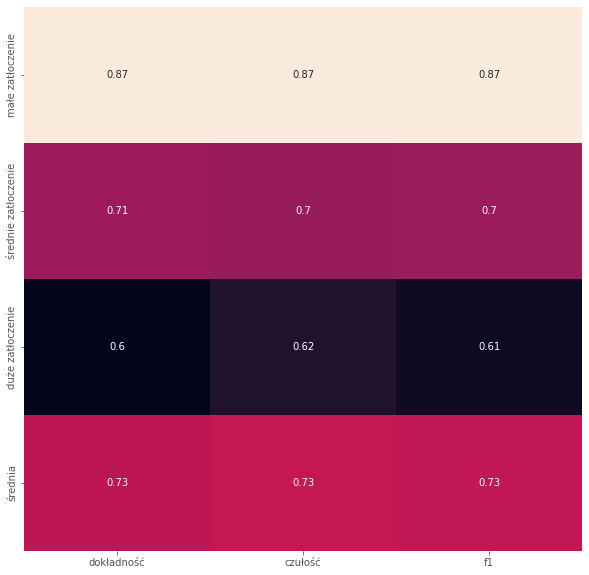

In [22]:
plot_classification_report(y_tests4, predicted4)

### RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model = RandomForestClassifier(max_depth = 100, random_state = 1)

In [ ]:
#Bootstrap Out of Bag
predicted2 = np.array([])
y_tests2 = np.array([])
for value in data_lines.values():
    X_train, X_test, y_train, y_test = value
    scores2 = cross_validate(model, X_train, y_train, cv = BootstrapOutOfBag(n_splits=5, random_seed=456), n_jobs = -1, return_estimator = True)

    predicted2 = np.concatenate((predicted2, scores2['estimator'][scores2['test_score'].argmax()].predict(X_test)), axis=0)
    y_tests2 = np.concatenate((y_tests2, y_test.to_numpy().reshape(1,-1)[0]), axis=0)
err2 = accuracy_score(predicted2, y_tests2)

In [ ]:
#Repeated K-Fold
predicted3 = np.array([])
y_tests3 = np.array([])
for value in data_lines.values():
    X_train, X_test, y_train, y_test = value
    scores3 = cross_validate(model, X_train, y_train, n_jobs = -1, cv = RepeatedKFold(n_splits = 10, n_repeats = 2), return_estimator = True)

    predicted3 = np.concatenate((predicted3, scores3['estimator'][scores3['test_score'].argmax()].predict(X_test)), axis=0)
    y_tests3 = np.concatenate((y_tests3, y_test.to_numpy().reshape(1,-1)[0]), axis=0)
err3 = accuracy_score(predicted3, y_tests3)

In [ ]:
#K-Fold
predicted4 = np.array([])
y_tests4 = np.array([])
for value in data_lines.values():
    X_train, X_test, y_train, y_test = value
    scores4 = cross_validate(model, X_train, y_train, cv = KFold(10), n_jobs=-1, return_estimator = True)

    predicted4 = np.concatenate((predicted4, scores4['estimator'][scores4['test_score'].argmax()].predict(X_test)), axis=0)
    y_tests4 = np.concatenate((y_tests4, y_test.to_numpy().reshape(1,-1)[0]), axis=0)
err4 = accuracy_score(predicted4, y_tests4)

In [ ]:
print("------- Accuracy --------")
print(f"2. Accuracy BootstrapOutOfBag {err2}")
print(f"3. Accuracy RepeatedKFold {err3}")
print(f"4. Accuracy KFold {err4}")

------- Accuracy --------
2. Accuracy BootstrapOutOfBag 0.8154926046628228
3. Accuracy RepeatedKFold 0.8347956881423916
4. Accuracy KFold 0.8342943093507145


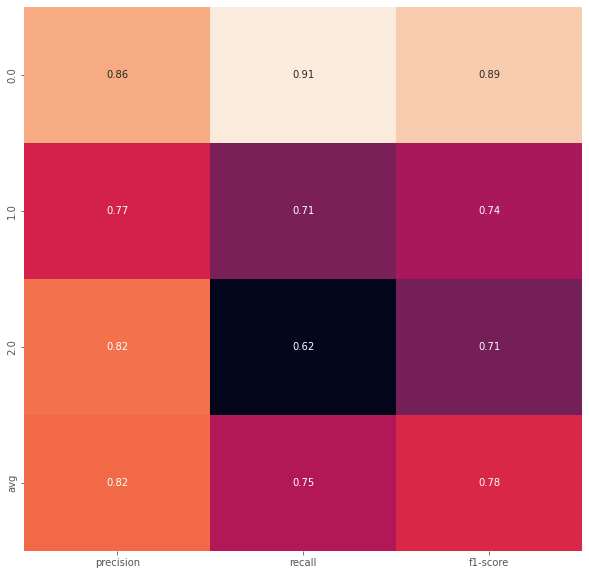

In [ ]:
plot_classification_report(y_tests3, predicted3)

### RUSBoostClassifier

In [ ]:
from imblearn.ensemble import RUSBoostClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score

In [ ]:
predicted = np.array([])
y_tests = np.array([])
for value in data_lines.values():
    X_train, X_test, y_train, y_test = value
    rusboost = RUSBoostClassifier(n_estimators=50, base_estimator = DecisionTreeClassifier(max_depth = 1000, random_state = 1), algorithm='SAMME', random_state=1)
    rusboost.fit(X_train, y_train)

    predicted = np.concatenate((predicted, rusboost.predict(X_test)), axis=0)
    y_tests = np.concatenate((y_tests, y_test.to_numpy().reshape(1,-1)[0]), axis=0)
print("Resampled accuracy: {:.2f}".format(accuracy_score(y_tests, predicted)))
print("Resampled balanced accuracy: {:.2f}".format(balanced_accuracy_score(y_tests, predicted)))

C:\Users\Patryk\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Patryk\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RUSBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\Patryk\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Patryk\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RUSBoostClassifier was fitted with feature names

Resampled accuracy: 0.64
Resampled balanced accuracy: 0.69


C:\Users\Patryk\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RUSBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\Patryk\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Patryk\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RUSBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\Patryk\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or

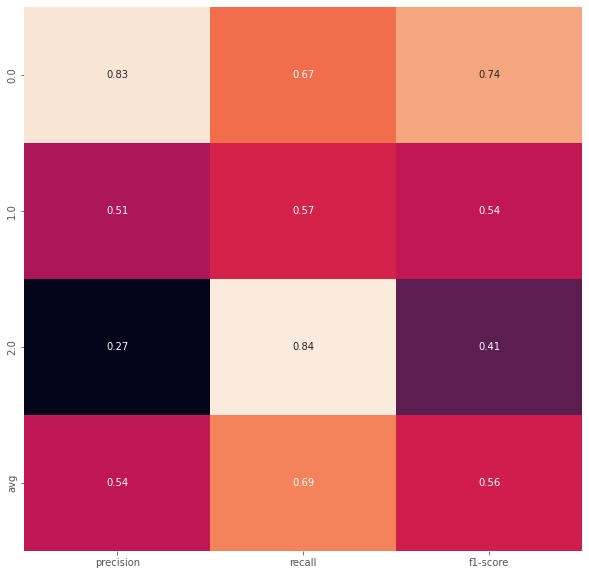

In [ ]:
plot_classification_report(y_tests, predicted)

In [ ]:
predicted = np.array([])
y_tests = np.array([])
for value in data_lines.values():
    X_train, X_test, y_train, y_test = value
    rusboost = RUSBoostClassifier(n_estimators=50, base_estimator = RandomForestClassifier(max_depth = 1000, random_state = 1), algorithm='SAMME', random_state=1)
    rusboost.fit(X_train, y_train)

    predicted = np.concatenate((predicted, rusboost.predict(X_test)), axis=0)
    y_tests = np.concatenate((y_tests, y_test.to_numpy().reshape(1,-1)[0]), axis=0)
print("Resampled accuracy: {:.2f}".format(accuracy_score(y_tests, predicted)))
print("Resampled balanced accuracy: {:.2f}".format(balanced_accuracy_score(y_tests, predicted)))

C:\Users\Patryk\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Patryk\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RUSBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\Patryk\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Patryk\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RUSBoostClassifier was fitted with feature names

Resampled accuracy: 0.65
Resampled balanced accuracy: 0.71


C:\Users\Patryk\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RUSBoostClassifier was fitted with feature names
  warnings.warn(


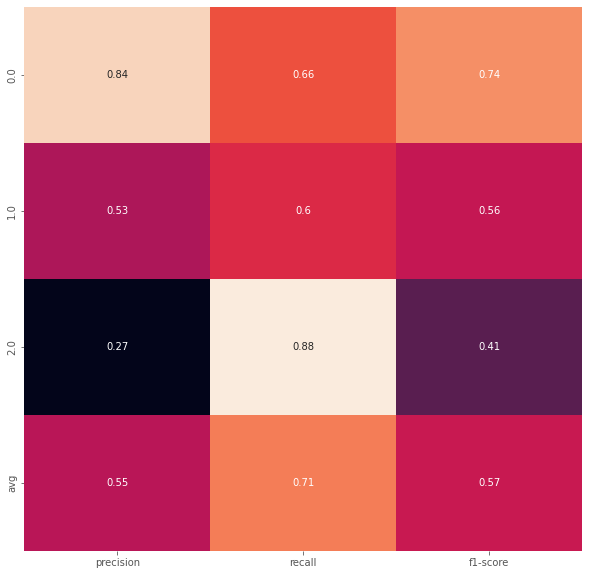

In [ ]:
plot_classification_report(y_tests, predicted)

## Regresja

In [ ]:
data_lines = dict()
for key, value in lines.items():
    data_lines[key] = get_train_and_test_for_lines(value, X_columns = features, y_columns = regress_labels)

### DecisionTreeRegressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
model = DecisionTreeRegressor(max_depth = 1000, random_state = 1)

In [ ]:
#Bootstrap Out of Bag
predicted2 = np.array([])
y_tests2 = np.array([])
for value in data_lines.values():
    X_train, X_test, y_train, y_test = value
    scores2 = cross_validate(model, X_train, y_train, cv = BootstrapOutOfBag(n_splits=5, random_seed=456), n_jobs = -1, return_estimator = True)

    predicted2 = np.concatenate((predicted2, scores2['estimator'][scores2['test_score'].argmax()].predict(X_test)), axis=0)
    y_tests2 = np.concatenate((y_tests2, y_test.to_numpy().reshape(1,-1)[0]), axis=0)
err2 = abs(predicted2 - y_tests2)

In [ ]:
#Repeated K-Fold
predicted3 = np.array([])
y_tests3 = np.array([])
for value in data_lines.values():
    X_train, X_test, y_train, y_test = value
    scores3 = cross_validate(model, X_train, y_train, n_jobs = -1, cv = RepeatedKFold(n_splits = 10, n_repeats = 2), return_estimator = True)

    predicted3 = np.concatenate((predicted3, scores3['estimator'][scores3['test_score'].argmax()].predict(X_test)), axis=0)
    y_tests3 = np.concatenate((y_tests3, y_test.to_numpy().reshape(1,-1)[0]), axis=0)
err3 = abs(predicted3 - y_tests3)

In [ ]:
#K-Fold
predicted4 = np.array([])
y_tests4 = np.array([])
for value in data_lines.values():
    X_train, X_test, y_train, y_test = value
    scores4 = cross_validate(model, X_train, y_train, cv = KFold(10), n_jobs=-1, return_estimator = True)

    predicted4 = np.concatenate((predicted4, scores4['estimator'][scores4['test_score'].argmax()].predict(X_test)), axis=0)
    y_tests4 = np.concatenate((y_tests4, y_test.to_numpy().reshape(1,-1)[0]), axis=0)
err4 = abs(predicted4 - y_tests4)

In [ ]:
d_err = []
d_err = pd.DataFrame({'Err':err2.reshape(-1), 'Type': 'BootOOB'})
d_err = d_err.append(pd.DataFrame({'Err':err3.reshape(-1), 'Type': 'Repeated KFold'}),ignore_index=True)
d_err = d_err.append(pd.DataFrame({'Err':err4.reshape(-1), 'Type': 'KFold'}),ignore_index=True)

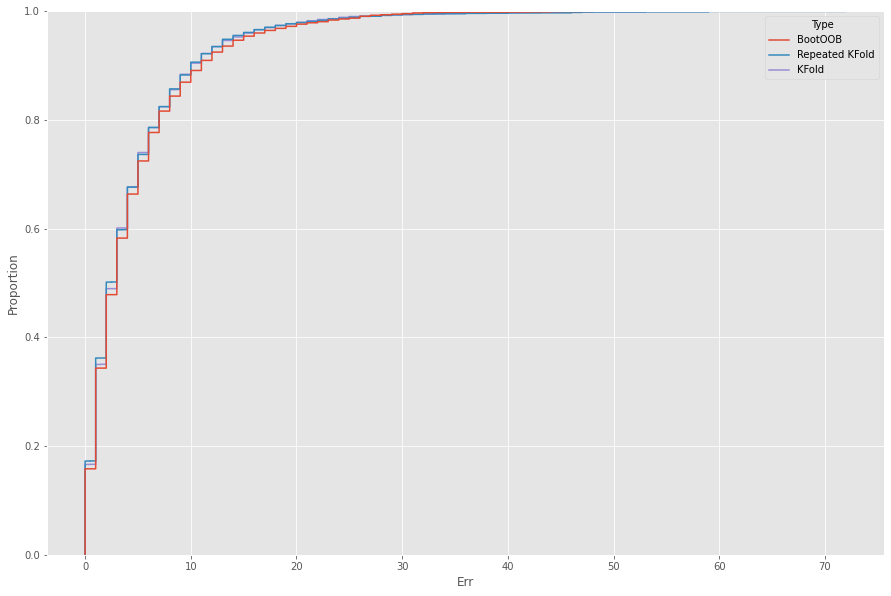

In [ ]:
plt.figure(figsize = (15,10))
g = sns.ecdfplot(d_err, x = "Err", hue = 'Type')
#g.set(xlim = (0, 10))

In [ ]:
stats = d_err.groupby('Type').describe().round(2)
stats

Err                                      
                 count  mean   std  min  25%  50%  75%   max
Type                                                        
BootOOB         3989.0  4.48  5.44  0.0  1.0  3.0  6.0  48.0
KFold           3989.0  4.31  5.52  0.0  1.0  3.0  6.0  72.0
Repeated KFold  3989.0  4.30  5.64  0.0  1.0  2.0  6.0  72.0

Accuracy: 0.78541


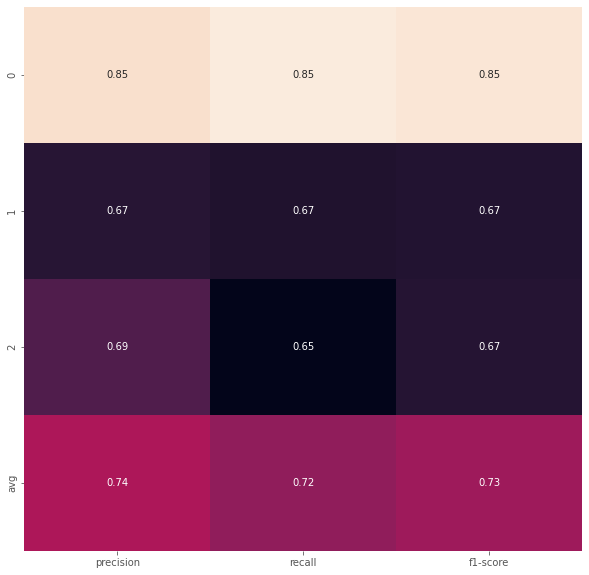

In [ ]:
accuracy_of_regression(y_tests4, np.floor(predicted4), clustering_dict)

### RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
model = RandomForestRegressor(max_depth = 10, random_state = 1)

In [ ]:
#Bootstrap Out of Bag
predicted2 = np.array([])
y_tests2 = np.array([])
for value in data_lines.values():
    X_train, X_test, y_train, y_test = value
    scores2 = cross_validate(model, X_train, y_train, cv = BootstrapOutOfBag(n_splits=5, random_seed=456), n_jobs = -1, return_estimator = True)

    predicted2 = np.concatenate((predicted2, scores2['estimator'][scores2['test_score'].argmax()].predict(X_test)), axis=0)
    y_tests2 = np.concatenate((y_tests2, y_test.to_numpy().reshape(1,-1)[0]), axis=0)
err2 = abs(predicted2 - y_tests2)

In [ ]:
#Repeated K-Fold
predicted3 = np.array([])
y_tests3 = np.array([])
for value in data_lines.values():
    X_train, X_test, y_train, y_test = value
    scores3 = cross_validate(model, X_train, y_train, n_jobs = -1, cv = RepeatedKFold(n_splits = 10, n_repeats = 2), return_estimator = True)

    predicted3 = np.concatenate((predicted3, scores3['estimator'][scores3['test_score'].argmax()].predict(X_test)), axis=0)
    y_tests3 = np.concatenate((y_tests3, y_test.to_numpy().reshape(1,-1)[0]), axis=0)
err3 = abs(predicted3 - y_tests3)

In [ ]:
#K-Fold
predicted4 = np.array([])
y_tests4 = np.array([])
for value in data_lines.values():
    X_train, X_test, y_train, y_test = value
    scores4 = cross_validate(model, X_train, y_train, cv = KFold(10), n_jobs=-1, return_estimator = True)

    predicted4 = np.concatenate((predicted4, scores4['estimator'][scores4['test_score'].argmax()].predict(X_test)), axis=0)
    y_tests4 = np.concatenate((y_tests4, y_test.to_numpy().reshape(1,-1)[0]), axis=0)
err4 = abs(predicted4 - y_tests4)

In [ ]:
d_err = []
d_err = pd.DataFrame({'Err':err2.reshape(-1), 'Type': 'BootOOB'})
d_err = d_err.append(pd.DataFrame({'Err':err3.reshape(-1), 'Type': 'Repeated KFold'}),ignore_index=True)
d_err = d_err.append(pd.DataFrame({'Err':err4.reshape(-1), 'Type': 'KFold'}),ignore_index=True)

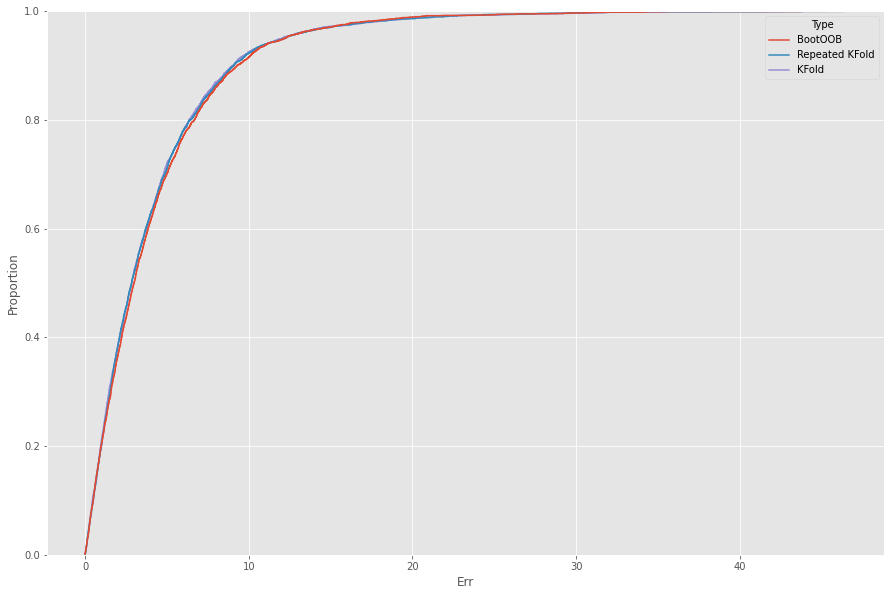

In [ ]:
plt.figure(figsize = (15,10))
g = sns.ecdfplot(d_err, x = "Err", hue = 'Type')
#g.set(xlim = (0, 10))

In [ ]:
stats = d_err.groupby('Type').describe().round(2)
stats

Err                                           
                 count  mean   std   min   25%   50%   75%    max
Type                                                             
BootOOB         3989.0  4.22  4.38  0.00  1.28  2.99  5.71  46.50
KFold           3989.0  4.11  4.42  0.00  1.21  2.85  5.52  45.38
Repeated KFold  3989.0  4.14  4.40  0.01  1.24  2.84  5.50  46.26

Accuracy: 0.78015


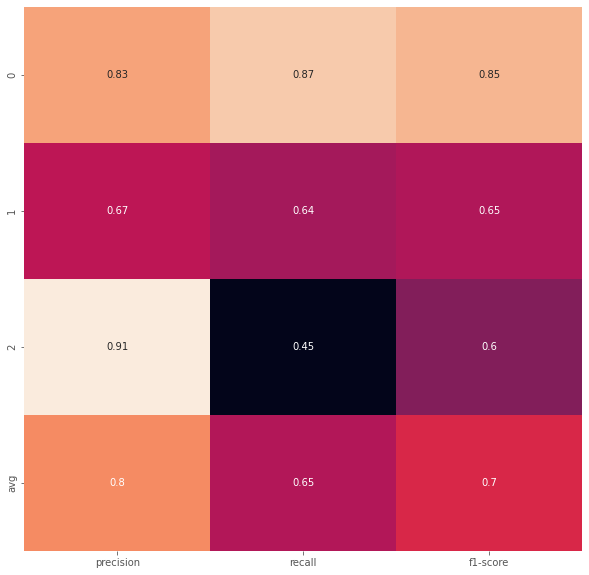

In [ ]:
accuracy_of_regression(y_tests3, np.floor(predicted3), clustering_dict)